# Sign Language Data Analysis

This notebook analyzes the sign language data collected using MediaPipe, examining the structure of hand and pose landmarks stored in the .npy files.

In [1]:
import numpy as np
import os
from module.helper_functions import get_data_path

# Get path to data directory
data_path = get_data_path()
print(f"Data path: {data_path}")

# List available actions/signs
actions = [action for action in os.listdir(data_path) if not action.startswith('.')]
if actions:
    print(f"Available signs: {actions}")
    
    # Pick the first action
    action = actions[0]
    
    # Get sequences for this action
    sequences = [seq for seq in os.listdir(os.path.join(data_path, action)) if not seq.startswith('.')]
    if sequences:
        # Pick the first sequence
        sequence = sequences[0]
        
        # Get frames for this sequence
        frames = [f for f in os.listdir(os.path.join(data_path, action, sequence)) if f.endswith('.npy')]
        if frames:
            # Pick the first frame
            frame = frames[0]
            
            # Full path to the file
            file_path = os.path.join(data_path, action, sequence, frame)
            print(f"Opening file: {file_path}")
            
            # Load the data and show shape
            data = np.load(file_path)
            print(f"Data shape: {data.shape}")
            
            # Show more details about the data structure
            print(f"Data type: {data.dtype}")
            
            # Show first few values
            print(f"First 10 values: {data[:10]}")
            
            # If we expect specific structure (126 values - 63 for each hand)
            if len(data) >= 126:
                left_hand = data[:63]
                right_hand = data[63:126]
                pose = data[126:]
                print(f"Left hand data shape: {left_hand.shape}")
                print(f"Right hand data shape: {right_hand.shape}")
                print(f"Pose data shape: {pose.shape}")
else:
    print("No sign data found in the data directory.")

Data path: /Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/data
Available signs: ['nice', 'how', 'no', 'thankyou', 'understand', 'take care', 'goodbye', 'later', 'hello', 'you', 'yes', 'SPACE', 'fine']
Opening file: /Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/data/nice/thinh_27/20.npy
Data shape: (225,)
Data type: float64
First 10 values: [ 0.52879113  0.34216291 -0.42250499  0.55527371  0.27679029 -0.37925655
  0.56517237  0.27940774 -0.37912342  0.57664025]
Left hand data shape: (63,)
Right hand data shape: (63,)
Pose data shape: (99,)


In [34]:
from module.data_processing import SignLanguageDataset, organize_data_for_testing

from torch.utils.data import Dataset, DataLoader




In [36]:
organize_data_for_testing(train_split = 0.8 )


Removing existing directory: data_train
Removing existing directory: data_test
Data organized into data_train and data_test directories
Training data: 80%, Testing data: 20%


## Data Loading and Validation

Let's first check if our data directories are properly organized before creating the DataLoaders.

In [37]:
# Check the data directory structure
train_dir = "data_train"
test_dir = "data_test"

def check_data_directory(directory):
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist!")
        return False
    
    actions = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')]
    if not actions:
        print(f"No action folders found in {directory}")
        return False
    
    print(f"Found {len(actions)} action classes in {directory}: {actions}")
    
    # Check sequences and frames for each action
    for action in actions:
        action_path = os.path.join(directory, action)
        sequences = [d for d in os.listdir(action_path) if os.path.isdir(os.path.join(action_path, d)) and not d.startswith('.')]
        print(f"  - Action '{action}' has {len(sequences)} sequences")
        
        if sequences:
            # Check frames in the first sequence
            first_seq = sequences[0]
            seq_path = os.path.join(action_path, first_seq)
            frames = [f for f in os.listdir(seq_path) if f.endswith('.npy')]
            print(f"    - Sequence '{first_seq}' has {len(frames)} frames")
            
            # Check shape of the first frame
            if frames:
                frame_path = os.path.join(seq_path, frames[0])
                try:
                    frame_data = np.load(frame_path)
                    print(f"    - Frame shape: {frame_data.shape}")
                except Exception as e:
                    print(f"    - Error loading frame: {e}")
    
    return True

print("Checking training data:")
train_ok = check_data_directory(train_dir)

print("\nChecking testing data:")
test_ok = check_data_directory(test_dir)

Checking training data:
Found 13 action classes in data_train: ['nice', 'how', 'no', 'thankyou', 'understand', 'take care', 'goodbye', 'later', 'hello', 'you', 'yes', 'SPACE', 'fine']
  - Action 'nice' has 24 sequences
    - Sequence 'thinh_27' has 30 frames
    - Frame shape: (225,)
  - Action 'how' has 24 sequences
    - Sequence 'thinh_27' has 30 frames
    - Frame shape: (225,)
  - Action 'no' has 24 sequences
    - Sequence 'man_12' has 30 frames
    - Frame shape: (225,)
  - Action 'thankyou' has 24 sequences
    - Sequence 'man_12' has 30 frames
    - Frame shape: (225,)
  - Action 'understand' has 24 sequences
    - Sequence 'man_12' has 30 frames
    - Frame shape: (225,)
  - Action 'take care' has 24 sequences
    - Sequence 'thinh_27' has 30 frames
    - Frame shape: (225,)
  - Action 'goodbye' has 24 sequences
    - Sequence 'man_12' has 30 frames
    - Frame shape: (225,)
  - Action 'later' has 40 sequences
    - Sequence 'thinh_35' has 30 frames
    - Frame shape: (225,)


In [38]:
# Create dataset and dataloader with proper error handling
import torch
from torch.utils.data import DataLoader

if train_ok and test_ok:
    try:
        # Create datasets
        train_dataset = SignLanguageDataset("data_train")
        test_dataset = SignLanguageDataset("data_test")
        
        print(f"Training dataset size: {len(train_dataset)}")
        print(f"Testing dataset size: {len(test_dataset)}")
        
        # Create dataloaders with a smaller batch size to avoid memory issues
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
        
        print("DataLoaders created successfully")
        
        # Test a single batch
        print("\nFetching a single batch from training dataloader...")
        for batch in train_loader:
            # The dataset returns a tuple of (data, label) not a dictionary
            inputs, labels = batch
            print(f"Batch data shape: {inputs.shape}")
            print(f"Batch labels shape: {labels.shape}")
            print(f"Batch labels: {labels}")
            break
            
        print("\nFetching a single batch from testing dataloader...")
        for batch in test_loader:
            # The dataset returns a tuple of (data, label) not a dictionary
            inputs, labels = batch
            print(f"Batch data shape: {inputs.shape}")
            print(f"Batch labels shape: {labels.shape}")
            print(f"Batch labels: {labels}")
            break
    except Exception as e:
        print(f"Error creating or using DataLoaders: {e}")
else:
    print("Data directory check failed. Please fix the issues before continuing.")

Training dataset size: 331
Testing dataset size: 83
DataLoaders created successfully

Fetching a single batch from training dataloader...
Batch data shape: torch.Size([32, 30, 225])
Batch labels shape: torch.Size([32])
Batch labels: tensor([ 4, 12,  7,  5,  6, 12, 12,  8, 10,  2, 11,  2, 12, 10, 11,  9,  3, 12,
         1,  9, 10,  1,  1,  1, 11,  7,  4,  0,  3, 12,  6,  5])

Fetching a single batch from testing dataloader...
Batch data shape: torch.Size([32, 30, 225])
Batch labels shape: torch.Size([32])
Batch labels: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4, 5, 5])


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Check available actions and define model parameters
train_actions = [action for action in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, action))]
num_classes = len(train_actions)
input_size = 225  # Input features size
hidden_sizes = [128, 64, 32]  # Hidden sizes for the three LSTM layers


class SignLanguageLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(SignLanguageLSTM, self).__init__()
        # Define the three LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_sizes[0], num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_sizes[0], hidden_sizes[1], num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_sizes[1], hidden_sizes[2], num_layers=1, batch_first=True)
        # Define the dense layers
        self.fc1 = nn.Linear(hidden_sizes[2], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        # Pass through the first LSTM and apply ReLU
        out, _ = self.lstm1(x)
        out = F.relu(out)
        # Pass through the second LSTM and apply ReLU
        out, _ = self.lstm2(out)
        out = F.relu(out)
        # Pass through the third LSTM, take the last time step, and apply ReLU
        out, _ = self.lstm3(out)
        out = out[:, -1, :]  # Shape: (batch_size, hidden_sizes[2])
        out = F.relu(out)
        # Pass through the dense layers with ReLU
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        # Output layer with softmax
        out = self.fc3(out)
        out = F.softmax(out, dim=1)
        return out

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SignLanguageLSTM(input_size, hidden_sizes, num_classes).to(device)

print(f"Model created for {num_classes} classes: {train_actions}")
print(f"Using device: {device}")
print(model)

Model created for 13 classes: ['nice', 'how', 'no', 'thankyou', 'understand', 'take care', 'goodbye', 'later', 'hello', 'you', 'yes', 'SPACE', 'fine']
Using device: cpu
SignLanguageLSTM(
  (lstm1): LSTM(225, 128, batch_first=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (lstm3): LSTM(64, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=13, bias=True)
)


## Training Function

Define functions to train and evaluate the model.

In [40]:
import time
from datetime import datetime
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    
    # Lists to track metrics
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    epochs = []
    
    # Training loop
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, batch in enumerate(train_loader):
            # Get the inputs and labels - dataset returns tuples, not dictionaries
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Log training progress
            if (i + 1) % 10 == 0 or (i + 1) == total_step:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
        
        # Evaluate the model
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                # Get the inputs and labels - dataset returns tuples, not dictionaries
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        # Calculate statistics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        
        # Store metrics for plotting
        epochs.append(epoch + 1)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Update learning rate scheduler
        scheduler.step(test_loss)
        
        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs, train_losses, label='Train Loss')
    ax1.plot(epochs, test_losses, label='Test Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accuracies, label='Train Accuracy')
    ax2.plot(epochs, test_accuracies, label='Test Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return final metrics
    return model, train_accuracies[-1], test_accuracies[-1]

## Train the Model

Now let's train the model using our data.

In [43]:
# Set training parameters
from module.helper_functions import get_model_path


num_epochs = 100
learning_rate = 0.001
batch_size = 32

# Check if we have valid data loaders before training
if 'train_loader' in locals() and 'test_loader' in locals():
    # Train the model
    print("Starting model training...")
    trained_model, final_train_accuracy, final_test_accuracy = train_model(model, train_loader, test_loader, 
                                              num_epochs=num_epochs, 
                                              learning_rate=learning_rate)
    
    # Save the trained model
    # os.makedirs("model", exist_ok=True)
    model_path = get_model_path()
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    print(f"Model path: {model_path}")
    model_save_path = os.path.join(model_path, "sign_language_model.pth")
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    
    print(f"Training completed! Final train accuracy: {final_train_accuracy:.2f}%, Final test accuracy: {final_test_accuracy:.2f}%")
else:
    print("Data loaders not properly initialized. Please check the data loading section.")

Starting model training...
Epoch [1/1000], Step [10/11], Loss: 1.8789
Epoch [1/1000], Step [11/11], Loss: 2.3168
Epoch [1/1000] - Train Loss: 2.1133, Train Acc: 59.21%, Test Loss: 2.0897, Test Acc: 57.83%
Epoch [2/1000], Step [10/11], Loss: 2.1478
Epoch [2/1000], Step [11/11], Loss: 1.9886
Epoch [2/1000] - Train Loss: 2.1269, Train Acc: 55.29%, Test Loss: 2.1461, Test Acc: 54.22%
Epoch [3/1000], Step [10/11], Loss: 2.2569
Epoch [3/1000], Step [11/11], Loss: 2.2527
Epoch [3/1000] - Train Loss: 2.2432, Train Acc: 44.11%, Test Loss: 2.2099, Test Acc: 44.58%
Epoch [4/1000], Step [10/11], Loss: 2.1795
Epoch [4/1000], Step [11/11], Loss: 2.3134
Epoch [4/1000] - Train Loss: 2.2108, Train Acc: 47.13%, Test Loss: 2.1104, Test Acc: 57.83%
Epoch [5/1000], Step [10/11], Loss: 2.1700
Epoch [5/1000], Step [11/11], Loss: 2.0543
Epoch [5/1000] - Train Loss: 2.1367, Train Acc: 57.40%, Test Loss: 2.1161, Test Acc: 57.83%
Epoch [6/1000], Step [10/11], Loss: 2.1589
Epoch [6/1000], Step [11/11], Loss: 2.01

KeyboardInterrupt: 

In [44]:
import time
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

def train_model_NNLOSS(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    # Loss function and optimizer
    criterion = nn.NLLLoss()  # Changed to NLLLoss for softmax outputs
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    
    # Lists to track metrics
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    epochs = []
    
    # Training loop
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, batch in enumerate(train_loader):
            # Get the inputs and labels - dataset returns tuples, not dictionaries
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            log_outputs = torch.log(outputs + 1e-8)  # Compute log probabilities
            loss = criterion(log_outputs, labels)  # Use log probabilities with NLLLoss
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Log training progress
            if (i + 1) % 10 == 0 or (i + 1) == total_step:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
        
        # Evaluate the model
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                # Get the inputs and labels - dataset returns tuples, not dictionaries
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                log_outputs = torch.log(outputs + 1e-8)  # Compute log probabilities
                loss = criterion(log_outputs, labels)  # Use log probabilities with NLLLoss
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        # Calculate statistics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        
        # Store metrics for plotting
        epochs.append(epoch + 1)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Update learning rate scheduler
        scheduler.step(test_loss)
        
        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs, train_losses, label='Train Loss')
    ax1.plot(epochs, test_losses, label='Test Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accuracies, label='Train Accuracy')
    ax2.plot(epochs, test_accuracies, label='Test Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return final metrics
    return model, train_accuracies[-1], test_accuracies[-1]

Starting model training...
Epoch [1/100], Step [10/11], Loss: 0.6245
Epoch [1/100], Step [11/11], Loss: 0.0468
Epoch [1/100] - Train Loss: 0.5522, Train Acc: 83.38%, Test Loss: 0.6525, Test Acc: 80.72%
Epoch [2/100], Step [10/11], Loss: 0.4372
Epoch [2/100], Step [11/11], Loss: 0.4079
Epoch [2/100] - Train Loss: 0.4444, Train Acc: 83.08%, Test Loss: 0.6118, Test Acc: 79.52%
Epoch [3/100], Step [10/11], Loss: 0.4790
Epoch [3/100], Step [11/11], Loss: 0.3945
Epoch [3/100] - Train Loss: 0.4965, Train Acc: 84.89%, Test Loss: 0.4296, Test Acc: 86.75%
Epoch [4/100], Step [10/11], Loss: 0.5908
Epoch [4/100], Step [11/11], Loss: 0.6070
Epoch [4/100] - Train Loss: 0.3655, Train Acc: 89.73%, Test Loss: 0.3310, Test Acc: 85.54%
Epoch [5/100], Step [10/11], Loss: 0.3508
Epoch [5/100], Step [11/11], Loss: 0.0789
Epoch [5/100] - Train Loss: 0.2385, Train Acc: 90.03%, Test Loss: 0.2365, Test Acc: 92.77%
Epoch [6/100], Step [10/11], Loss: 0.0898
Epoch [6/100], Step [11/11], Loss: 0.1756
Epoch [6/100] 

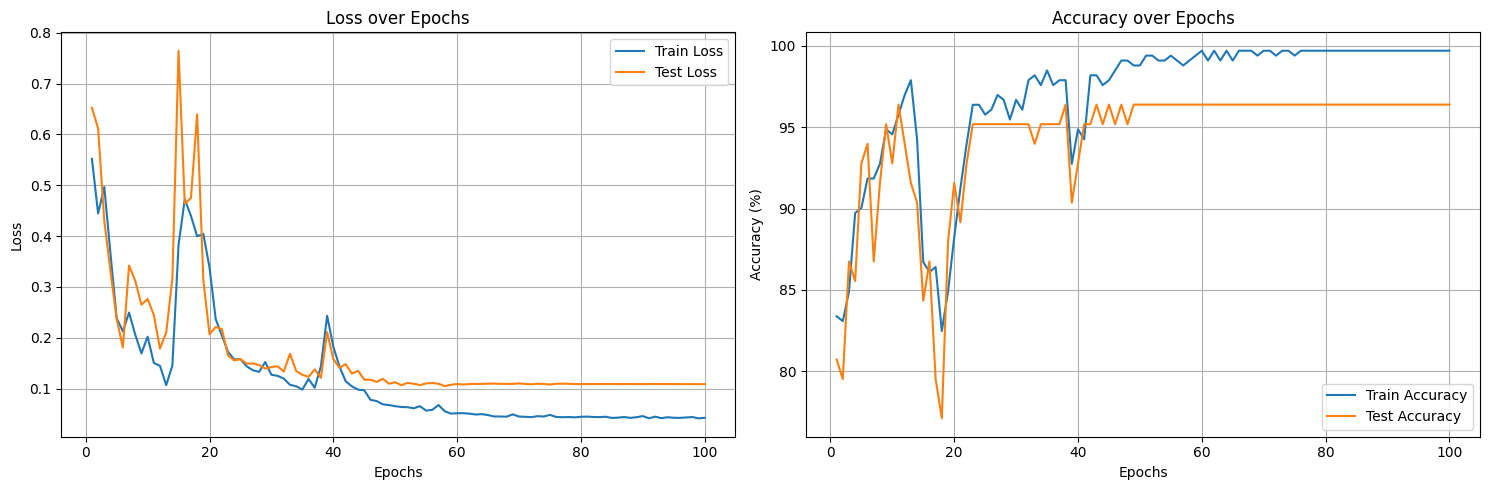

Model path: /Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/model
Model saved to /Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/model/sign_language_model.pth
Training completed! Final train accuracy: 99.70%, Final test accuracy: 96.39%


In [46]:
# Set training parameters
from module.helper_functions import get_model_path


num_epochs = 100
learning_rate = 0.001
batch_size = 32

# Check if we have valid data loaders before training
if 'train_loader' in locals() and 'test_loader' in locals():
    # Train the model
    print("Starting model training...")
    trained_model, final_train_accuracy, final_test_accuracy = train_model_NNLOSS(model, train_loader, test_loader, 
                                              num_epochs=num_epochs, 
                                              learning_rate=learning_rate)
    
    # Save the trained model
    # os.makedirs("model", exist_ok=True)
    model_path = get_model_path()
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    print(f"Model path: {model_path}")
    model_save_path = os.path.join(model_path, "sign_language_model.pth")
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    
    print(f"Training completed! Final train accuracy: {final_train_accuracy:.2f}%, Final test accuracy: {final_test_accuracy:.2f}%")
else:
    print("Data loaders not properly initialized. Please check the data loading section.")

## Real-Time Sign Language Detection

Now that we've trained our model, let's implement real-time detection using a webcam feed.

In [48]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import mediapipe as mp
from module.helper_functions import get_cam_idx
from module.helper_functions import get_model_path
from module.mediapipe_utils import mediapipe_detection, extract_keypoints

# Load the trained model if not already in memory
def load_model_if_needed():
    if 'trained_model' not in locals():
        model_path = get_model_path()
        model_file = os.path.join(model_path, "sign_language_model.pth")
        if os.path.exists(model_file):
            # Initialize model with same parameters as training
            model = SignLanguageLSTM(input_size, hidden_sizes, num_classes).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()  # Set to evaluation mode
            return model
        else:
            print(f"Model file not found at {model_file}")
            return None
    return trained_model

# Function to visualize probabilities
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num % len(colors)], -1)
        cv2.putText(output_frame, f'{actions[num]}: {prob:.2f}', 
                   (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

# Get trained model
model = load_model_if_needed()
if model is None:
    print("Please train the model first or make sure the model file exists.")
else:
    # Initialize detection variables
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.7  # Confidence threshold for prediction

    # Get list of actions from training directory
    actions = [action for action in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, action))]
    print(f"Detecting the following actions: {actions}")

    # Colors for visualization
    colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]

    # Initialize webcam
    # cap = cv2.VideoCapture(get_cam_idx())
    cap = cv2.VideoCapture(2)

    # Initialize MediaPipe model
    with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            # Read frame
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            from module.mediapipe_utils import draw_landmarks
            draw_landmarks(image, results)

            # Extract keypoints and add to sequence
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            
            # Keep only the last 30 frames
            sequence = sequence[-30:]

            # Prediction logic when we have enough frames
            if len(sequence) == 30:
                # Convert sequence to tensor and add batch dimension
                input_data = torch.tensor(np.array(sequence), dtype=torch.float32).unsqueeze(0).to(device)
                
                # Get prediction
                with torch.no_grad():
                    output = model(input_data)
                    # Convert from torch tensor to numpy
                    res = output.cpu().numpy()[0]
                    
                # Get predicted class index
                predicted_class = np.argmax(res)
                print(f"Predicted: {actions[predicted_class]} with confidence {res[predicted_class]:.2f}")
                predictions.append(predicted_class)

                # Visualization logic
                # Only add prediction to sentence if consistent over several frames
                if len(predictions) > 10 and np.unique(predictions[-10:])[0] == predicted_class:
                    if res[predicted_class] > threshold:
                        if len(sentence) == 0 or actions[predicted_class] != sentence[-1]:
                            sentence.append(actions[predicted_class])

                # Limit sentence length
                if len(sentence) > 5:
                    sentence = sentence[-5:]

                # Visualize probabilities
                image = prob_viz(res, actions, image, colors)

            # Display sentence
            cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # Show to screen
            cv2.imshow('Real-time Sign Language Detection', image)

            # Break loop with 'q' key
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        # Release resources
        cap.release()
        cv2.destroyAllWindows()

Detecting the following actions: ['nice', 'how', 'no', 'thankyou', 'understand', 'take care', 'goodbye', 'later', 'hello', 'you', 'yes', 'SPACE', 'fine']


I0000 00:00:1746357215.802300 4659942 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1746357215.910139 12348158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746357215.929156 12348160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746357215.931809 12348163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746357215.931828 12348157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746357215.932004 12348162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling sup

Predicted: SPACE with confidence 0.83
Predicted: SPACE with confidence 0.61
Predicted: SPACE with confidence 0.60
Predicted: SPACE with confidence 0.70
Predicted: SPACE with confidence 0.77
Predicted: SPACE with confidence 0.76
Predicted: SPACE with confidence 0.78
Predicted: SPACE with confidence 0.86
Predicted: SPACE with confidence 0.94
Predicted: SPACE with confidence 0.97
Predicted: SPACE with confidence 0.98
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 1.00
Predicted: SPACE with confidence 1.00
Predicted: SPACE with confidence 1.00
Predicted: SPACE with confidence 1.00
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: SPACE with confidence 0.99
Predicted: S

In [ ]:
import cv2
import numpy as np
import torch
import mediapipe as mp
from module.mediapipe_utils import mediapipe_detection, extract_keypoints, draw_landmarks

def load_model_for_inference():
    model = SignLanguageLSTM(input_size, hidden_sizes, num_classes).to(device)
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    return model

model = load_model_for_inference()
sequence, sentence, predictions = [], [], []
threshold = 0.7
cap = cv2.VideoCapture(0)

with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image, results = mediapipe_detection(frame, holistic)
        draw_landmarks(image, results)
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            input_data = torch.tensor(np.array(sequence), dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_data)
                res = output.cpu().numpy()[0]
            predicted_class = np.argmax(res)
            if res[predicted_class] > threshold:
                if not sentence or actions[predicted_class] != sentence[-1]:
                    sentence.append(actions[predicted_class])
            if len(sentence) > 5:
                sentence = sentence[-5:]

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        cv2.imshow('Real-time Sign Language Detection', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
